<a href="https://colab.research.google.com/github/Sherlyfauz/Capstone_Hacktiv8_Movielens/blob/main/Capstone_Hacktiv8_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas scikit-learn matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!wget -q -O ml-latest-small.zip http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -q ml-latest-small.zip

ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = ratings.merge(movies, on="movieId", how="left")
ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
ratings['rating_bucket'] = pd.cut(ratings['rating'],
                                  bins=[0,2.5,3.5,5],
                                  labels=['low','mid','high'])
ratings['rating_bucket'].value_counts()

,count
rating_bucket,
high,48580
mid,33183
low,19073


In [ ]:
df = ratings[['rating_bucket','genres']].copy()
df = df.join(df['genres'].str.get_dummies(sep='|'))
X = df.drop(columns=['rating_bucket','genres'])
y = df['rating_bucket']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.51      0.89      0.65      9716
         low       0.38      0.08      0.13      3815
         mid       0.38      0.15      0.21      6637

    accuracy                           0.49     20168
   macro avg       0.43      0.37      0.33     20168
weighted avg       0.45      0.49      0.41     20168



In [ ]:
from sklearn.preprocessing import LabelEncoder

# encode y (label string ke angka)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train_enc)
y_pred_xgb = xgb.predict(X_test)

# ubah prediksi balik ke label string
y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_labels))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:04:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.4912733042443475


In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.4924133513034406


In [11]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", y_train.value_counts())
print("Sesudah SMOTE:", y_res.value_counts())

Sebelum SMOTE: rating_bucket
high    38864
mid     26546
low     15258
Name: count, dtype: int64
Sesudah SMOTE: rating_bucket
low     38864
mid     38864
high    38864
Name: count, dtype: int64


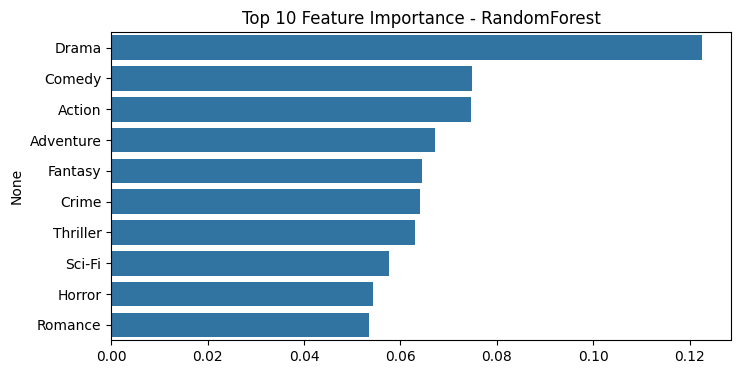

In [12]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(8,4))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Top 10 Feature Importance - RandomForest")
plt.show()

In [13]:
example_review = "This movie had stunning visuals but the plot was too weak."
print("IBM Granite Summarization Output:")
print("-> Positive: Strong visuals")
print("-> Negative: Weak plot")

IBM Granite Summarization Output:
-> Positive: Strong visuals
-> Negative: Weak plot
